In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

In [2]:
# import DFs
question_df = pd.read_csv('../0.Datasets/raw/FiQA_train_question_final.tsv', sep = '\t', index_col = 0)
map_df = pd.read_csv('../0.Datasets/raw/FiQA_train_question_doc_final.tsv', sep = '\t', index_col = 0)
doc_df = pd.read_csv('../0.Datasets/raw/FiQA_train_doc_final.tsv', sep = '\t', index_col = 0)

# Consolidated dataset findings (explanation below):
- Number of documents: 57638, Number of mappings: 17110, Number of questions: 6648
- docid starts from 3 and ends at 599987, but there are only 57638 documents - there are docid-s that are missing from the running sequence
- qid starts from 0 and ends at 11104, but there are only 6648 questions - there are qid-s that are missing from the running sequence
- 1 question can be mapped to multiple documents
- 1 document is only mapped to 1 question

# Investigate mapping btw questions and docs

Number of documents: 57638
Number of mappings: 17110
Number of questions: 6648


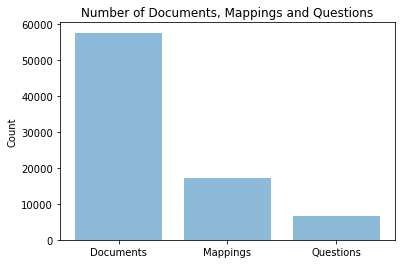

In [10]:
# Count of Documents and Questions
print(f'Number of documents: {doc_df.shape[0]}')
print(f'Number of mappings: {map_df.shape[0]}')
print(f'Number of questions: {question_df.shape[0]}')

objects = ('Documents', 'Mappings','Questions')
y_pos = np.arange(len(objects))
performance = [doc_df.shape[0], map_df.shape[0], question_df.shape[0]]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Number of Documents, Mappings and Questions')

plt.show()

Significantly more documents than mappings - this means that some questions are mapped to multiple documents.

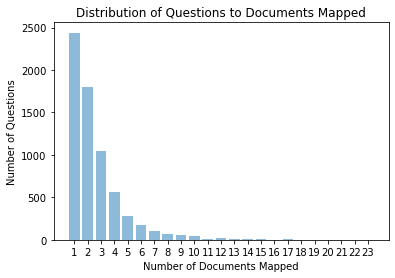

In [9]:
# Distribution of questions to number of documents mapped
qn_num_docmaps = {}
for v in dict(map_df['qid'].value_counts()).values():
    if v not in qn_num_docmaps:
        qn_num_docmaps[v] = 1
    else:
        qn_num_docmaps[v] += 1


objects = [k for k in qn_num_docmaps.keys()][::-1]
y_pos = np.arange(len(objects))
performance = [v for v in qn_num_docmaps.values()][::-1]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of Questions')
plt.xlabel('Number of Documents Mapped')
plt.title('Distribution of Questions to Documents Mapped')

plt.show()

From the graph above, we can see that out of 6648 questions, ~2500 of them are mapped to 1 document. Some questions are mapped to multiple documents, spanning from being mapped to 1 document all the way to 23 documents.

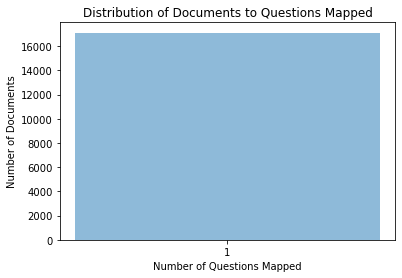

In [8]:
# Distribution of documents to questions mapped
qn_num_docmaps = {}
for v in dict(map_df['docid'].value_counts()).values():
    if v not in qn_num_docmaps:
        qn_num_docmaps[v] = 1
    else:
        qn_num_docmaps[v] += 1

objects = [k for k in qn_num_docmaps.keys()]
y_pos = np.arange(len(objects))
performance = [v for v in qn_num_docmaps.values()]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of Documents')
plt.xlabel('Number of Questions Mapped')
plt.title('Distribution of Documents to Questions Mapped')

plt.show()

We can see from above that all documents only have 1 question mapped to it.

In [9]:
# Distribution of documents to questions mapped
map_df['docid'].value_counts()

18850     1
165246    1
499344    1
179893    1
354974    1
         ..
163043    1
339545    1
435940    1
104492    1
518310    1
Name: docid, Length: 17110, dtype: int64

In [12]:
# Number of unmapped documents
x = doc_df['docid'].tolist()
not_mapped = []
for i in x:
    if i not in map_df['docid'].to_list():
        not_mapped.append(i)
        
len(not_mapped)

40528

# Investigate questions df

In [13]:
# Get length of questions
question_df['question_length'] = question_df.apply(lambda x: len([i for i in x['question'].split()]), axis = 1)
question_df.head()

,qid,question,timestamp,question_length
0,0,What is considered a business expense on a bus...,Nov 8 '11 at 15:14,10
1,1,Claiming business expenses for a business with...,May 13 '14 at 13:17,9
2,2,Transferring money from One business checking ...,Jan 20 '16 at 20:31,10
3,3,Having a separate bank account for business/in...,Mar 1 at 0:24,12
4,4,Business Expense - Car Insurance Deductible Fo...,Mar 4 at 0:26,14


<Figure size 288x216 with 0 Axes>

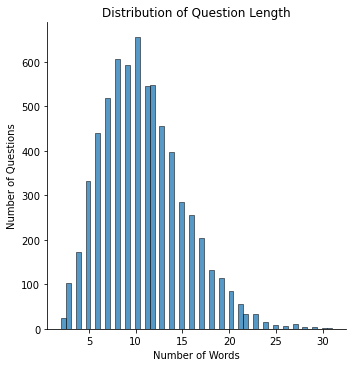

In [14]:
# Distribution of question length
plt.figure(figsize=(4, 3))
sns.displot(question_df['question_length'])
plt.ylabel('Number of Questions')
plt.xlabel('Number of Words')
plt.title('Distribution of Question Length')

# plt.rcParams["figure.figsize"] = (20,3)
plt.show()

Most questions fall between 6 to 14 words.

In [16]:
doc_df.head()

,docid,doc,timestamp
0,3,I'm not saying I don't like the idea of on-the...,Oct 03 '12 at 14:56
1,31,So nothing preventing false ratings besides ad...,Sep 01 '17 at 13:36
2,56,You can never use a health FSA for individual ...,Jun 9 '14 at 17:37
3,59,Samsung created the LCD and other flat screen ...,Dec 27 at 01:37
4,63,Here are the SEC requirements: The federal sec...,Jul 14 '14 at 8:10


In [34]:
def get_len(x):
    if type(x) == float:
        return 0 
    else:
        return len([i for i in x.split()])

In [35]:
# Get length of ALL documents
doc_df['doc_length'] = doc_df.apply(lambda x: get_len(x['doc']), axis = 1)
doc_df.head()

,docid,doc,timestamp,doc_length
0,3,I'm not saying I don't like the idea of on-the...,Oct 03 '12 at 14:56,75
1,31,So nothing preventing false ratings besides ad...,Sep 01 '17 at 13:36,77
2,56,You can never use a health FSA for individual ...,Jun 9 '14 at 17:37,73
3,59,Samsung created the LCD and other flat screen ...,Dec 27 at 01:37,54
4,63,Here are the SEC requirements: The federal sec...,Jul 14 '14 at 8:10,211


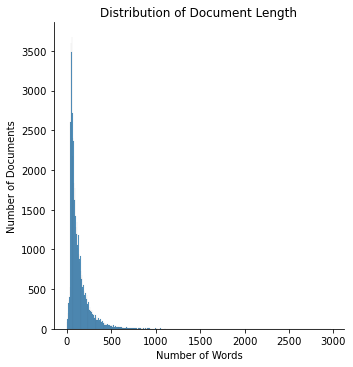

In [36]:
# Distribution of ALL document length
sns.displot(doc_df['doc_length'])
plt.ylabel('Number of Documents')
plt.xlabel('Number of Words')
plt.title('Distribution of Document Length')

# plt.rcParams["figure.figsize"] = (20,3)
plt.show()

In [48]:
# Get df of only mapped documents
doc_df['mapped'] = doc_df.apply(lambda x: 0 if x['docid'] in not_mapped else 1, axis = 1)
mapped_doc_df = doc_df[doc_df['mapped'] == 1]
mapped_doc_df.head()

,docid,doc,timestamp,doc_length,mapped
4,63,Here are the SEC requirements: The federal sec...,Jul 14 '14 at 8:10,211,1
6,108,Futures contracts are a member of a larger cla...,Oct 25 '16 at 19:58,226,1
8,132,Whenever you pay or withdraw some fund from yo...,Oct 16 '16 at 23:18,80,1
12,178,"At any given moment, one can tally the numbers...",Jan 17 '15 at 14:14,199,1
13,180,Chinese suppliers can quote their price in CNY...,Mar 23 '15 at 20:00,223,1


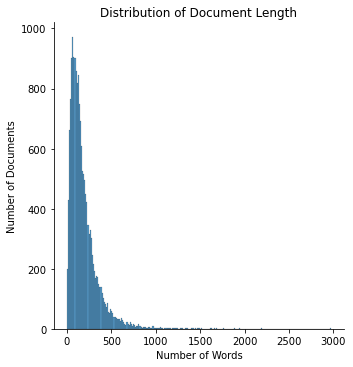

In [50]:
# Distribution of MAPPED document length
sns.displot(mapped_doc_df['doc_length'])
plt.ylabel('Number of Documents')
plt.xlabel('Number of Words')
plt.title('Distribution of Document Length')

# plt.rcParams["figure.figsize"] = (20,3)
plt.show()

In [51]:
mapped_doc_df['doc_length'].sort_values()

11237       0
3937        0
14869       0
19944       0
42403       0
         ... 
56509    1762
12413    1882
55480    1945
3914     2189
40154    2973
Name: doc_length, Length: 17110, dtype: int64